# Plotting data as a heat map

Heatmaps are very useful ways of plotting data. Basically, each little color on the plot or the "map" is related to a calculated value for the area. In some cases this can be a two dimensional histogram, in other cases it can be a calculated statistic associated with a spatial value, or even something else.

In this exercise we will plot the Global Earthquake Hazard Distribution - Peak Ground Acceleration 1976-2002. This data was collected by NASA and you can download it for free.

[Download Here.](http://sedac.ciesin.columbia.edu/data/set/ndh-earthquake-distribution-peak-ground-acceleration/data-download#close)

You will need to unzip the file you download.

This data set has a few interesting characteristics so lets import it and check it out. In this exercise the data will be stored in a data folder but you can put it anywhere you want.

*In this exercise, we went through the steps that we ACTUALLY went through to make the exercise. We did it this way instead of having every step working because we hope it shows that the scientific process is one of struggle.*

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_location = 'data/gdpga.asc'

df = pd.read_csv(data_location)

In [3]:
df.head(6)

,ncols 8640
0,nrows 3432
1,xllcorner -180
2,yllcorner -58.00833333333
3,cellsize 0.0416666666667
4,NODATA_value -9999
5,-9999 -9999 -9999 -9999 -9999 -9999 -9999 -999...


Sometimes data can contain header rows that describe the data you have. In this case it tells us how many columns there are to be expected and how many rows to be expected and the lower left corner of the latitude and longitude. It also tells us how big the plotted value should be.

In [4]:
df = pd.read_csv(data_location, skiprows=6, delim_whitespace=True,na_values=-9999)

In [5]:
df.columns.shape

(8640,)

In [6]:
df.index.shape

(3431,)

/home/max/anaconda2/envs/zoo/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


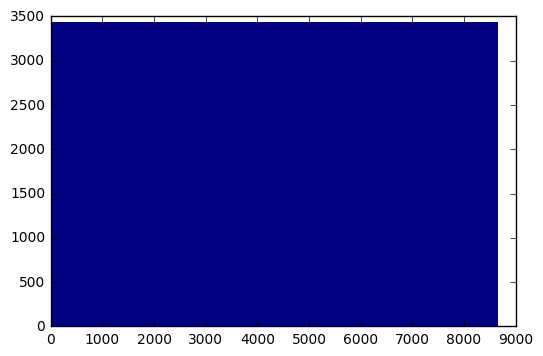

In [7]:
plt.pcolormesh(df.values)

In [8]:
df.values.max()

nan

# What happened?!

Data from NASA should be correct right? Maybe it downloaded wrong? The first thing I checked was the data I downloaded using a linux tool called `grep`:

    cat gdpga.asc | grep '[0-9]'
    
This failed. Why? Basically what this does is search the file for values that contain numbers 0 to 9. But since I am clever, (not really see immediately previous mistake) I ammended this to only search for numbers 0 to 8.

    cat gdpga.asc | grep '[0-8]'
    
This excludes any number that doesn't have 9 in it from being highlighted.

![yay the data isn't wrong](http://i.imgur.com/DYBP5fE.png)

Yay. Stuff is red. Red is good. The data isn't missing.

So what was wrong? I'm not entirely sure. Let's try and load the data with numpy instead of pandas.

In [9]:
data = np.loadtxt(data_location, skiprows=6)

In [10]:
data[0:5]

array([[-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.],
       [-9999., -9999., -9999., ..., -9999., -9999., -9999.]])

In [11]:
data.max()

10.0

In [12]:
data.min()

-9999.0

# Yay, there is data here.

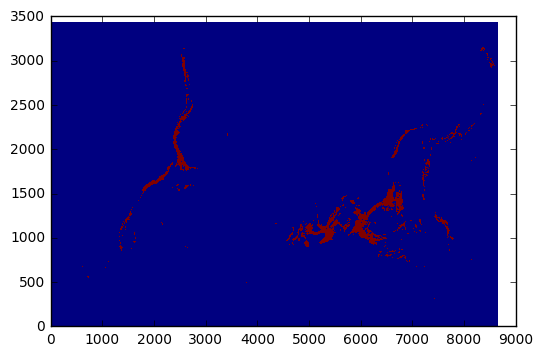

In [13]:
plt.pcolormesh(data)

# It annoys me to store data as -9999.0 instead of as NaN, lets get rid of that

In [14]:
data[data==-9999.] = np.nan

/home/max/anaconda2/envs/zoo/lib/python3.5/site-packages/matplotlib/colors.py:581: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


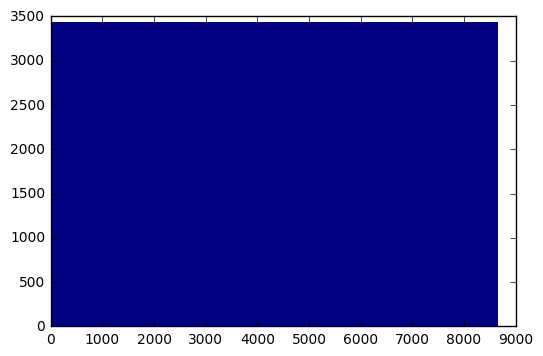

In [15]:
plt.pcolormesh(data)

# Where did all our data go?

In [16]:
data.max()

nan

# Now we know why we originally had no data when importing via pandas

So we can look at what we used to import the data:

    df = pd.read_csv(data_location, skiprows=6, delim_whitespace=True,na_values=-9999)
    
I just assumed that the header was correct that areas without data were -9999 and that pandas would *Do The Right Thing*. This obviously didn't happen. Note my error:

    na_values=-9999

If we get rid of this part pandas should work.

In [17]:
df = pd.read_csv(data_location, skiprows=6, delim_whitespace=True)

In [18]:
df.values.max()

10

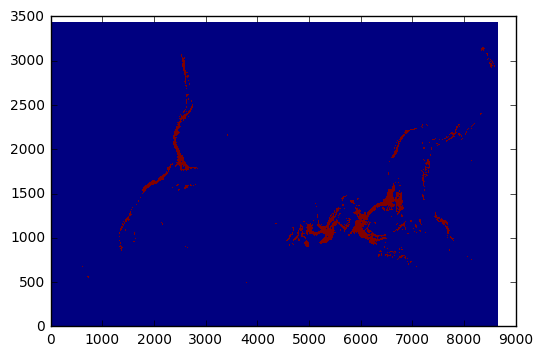

In [19]:
plt.pcolormesh(df.values)

# Yay it works!

But this data is actually map data, and we shouldn't plot data when it doesn't exist. 

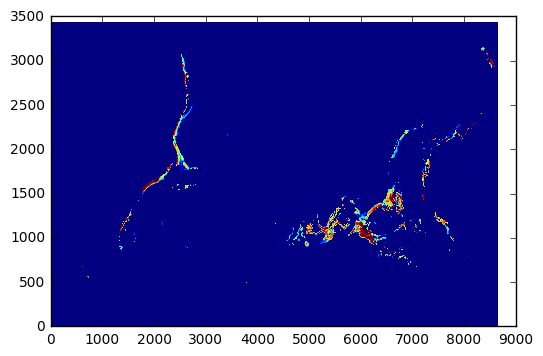

In [20]:
plt.pcolormesh(df.values, vmin=0, vmax=10)

This looks better but it still is plotting data where there are zeros. So we should replace the -9999 with np.nan

In [21]:
df.values[df.values==-9999.] = np.nan

ValueError: cannot convert float NaN to integer

# WHAT?!

This is really strange. But it means we are probably storing everything as ints instead of floats. np.nans are floats so since we are aware of this perhaps we can fix it. But first lets check if that hypothesis is correct:

In [22]:
masked_data = np.ma.masked_where(df.values<0,df.values)

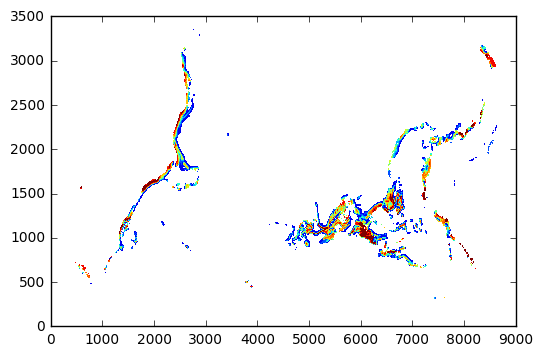

In [23]:
plt.pcolormesh(masked_data, vmin=0, vmax=10)

# Now that is a good looking graph!

But what is this masked business? Taken from the [scipy.org docs](https://docs.scipy.org/doc/numpy/reference/maskedarray.generic.html#what-is-a-masked-array):

    In many circumstances, datasets can be incomplete or tainted by the presence of invalid data. For example, a sensor may have failed to record a data, or recorded an invalid value. The numpy.ma module provides a convenient way to address this issue, by introducing masked arrays.

    A masked array is the combination of a standard numpy.ndarray and a mask. A mask is either nomask, indicating that no value of the associated array is invalid, or an array of booleans that determines for each element of the associated array whether the value is valid or not. 
    
What does this mean? Looking at a really simple example

In [24]:
a = np.arange(4)
a

array([0, 1, 2, 3])

In [25]:
np.ma.masked_where(a<=2, a)

masked_array(data = [-- -- -- 3],
             mask = [ True  True  True False],
       fill_value = 999999)

Thus for the PGA data, we MASK all values below zero. Since we are using `pcolormesh`, we have a lot of behind the scenes magic that knows what do with masked data and we get:

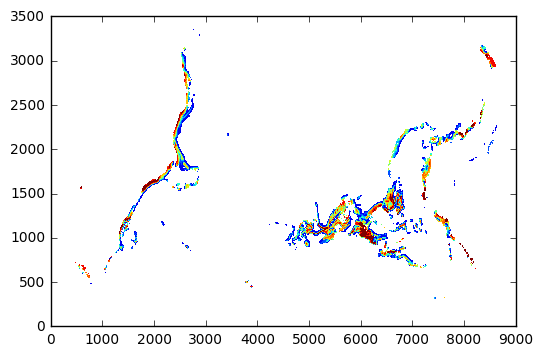

In [26]:
plt.pcolormesh(masked_data, vmin=0, vmax=10)

# But this is map data, it should go on a map.

The header from before tells us some much needed data on how to setup the map:

    xllcorner -180
    yllcorner -58.00833333333
    cellsize 0.0416666666667

Often times you see "LL". This means "lower left". We will see this in `basemap` when we make our maps.

# In the next lesson we will use this data set to make a map.